In [5]:
import torch
import torch.nn as nn
import cv2
import numpy as np

import gc
import os
import matplotlib.pyplot as plt
import time

from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T, models
from torchvision.utils import make_grid

In [6]:
HEIGHT = 320
WIDTH = 200

gc.enable()

In [7]:
class ImageDataset(Dataset):

    def __init__(self, path, code=cv2.COLOR_BGR2LAB, transform=T.ToTensor()):
        """
        :param path: Path to the image directory location.
        """
        imgs = None
        for folder, sub_folder, filenames in os.walk(path):
            imgs = [cv2.imread(os.path.join(path, file)) for file in filenames]
            imgs = [cv2.cvtColor(img, code) for img in imgs]
            imgs = [np.uint8(img) for img in imgs]

        self.imgs = imgs
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, subscript):
        if isinstance(subscript, slice):
            imgs = []
            for img in self.imgs[subscript.start:subscript.stop:subscript.step]:
                img = self.transform(img)
                imgs.append(img)
            return imgs
        else:
            return self.transform(self.imgs[subscript])

    def l_images(self):
        imgs = []
        for img in self.imgs:
            img = self.transform(img)
            imgs.append(img[:1, :, :])
        return imgs

    def ab_images(self):
        imgs = []
        for img in self.imgs:
            img = self.transform(img)
            imgs.append(img[1:, :, :])
        return imgs

#### Custom transformation class to resize images with ```OpenCV``` and later this class instance use with other transformation classes with ```transforms.Compose```.

In [10]:
tf_color = T.Compose([
    T.ToPILImage(),
    T.Resize(size=(HEIGHT, WIDTH)),
    T.ToTensor()
    # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

tf_gray = T.Compose([
    T.ToPILImage(),
    T.Resize(size=(HEIGHT, WIDTH)),
    T.ToTensor()
    # T.Normalize(mean=[0.485], std=[0.229])
])

gray_dataset = ImageDataset(path='C:/Datasets/Celeba/grayscale', transform=tf_gray, code=cv2.COLOR_BGR2GRAY)
rgb_dataset = ImageDataset(path='C:/Datasets/Celeba/sample', transform=tf_color, code=cv2.COLOR_BGR2RGB)
lab_dataset = ImageDataset(path='C:/Datasets/Celeba/sample', transform=tf_color, code=cv2.COLOR_BGR2LAB)

In [11]:
is_cuda = torch.cuda.is_available()
is_cuda

True

In [12]:
torch.manual_seed(101)

# GRAYSCALE IMAGES USE TO TRAIN NEURAL NETWORKS.
gray_data_loader = DataLoader(dataset=gray_dataset, batch_size=20, shuffle=True, pin_memory=is_cuda, num_workers=0)

In [13]:
rgb_data_loader = DataLoader(dataset=rgb_dataset, batch_size=10, shuffle=False, pin_memory=is_cuda, num_workers=0)
# LAB IMAGES FOR VISUALIZATION AND TRAINING PURPOSE.
lab_data_loader = DataLoader(dataset=lab_dataset, batch_size=10, shuffle=False, pin_memory=is_cuda, num_workers=0)
l_data_loader = DataLoader(dataset=lab_dataset.l_images(), batch_size=10, shuffle=False, pin_memory=is_cuda, num_workers=0)
ab_data_loader = DataLoader(dataset=lab_dataset.ab_images(), batch_size=10, shuffle=False ,pin_memory=is_cuda, num_workers=0)

#### View a single batch grayscale and colored image sample.

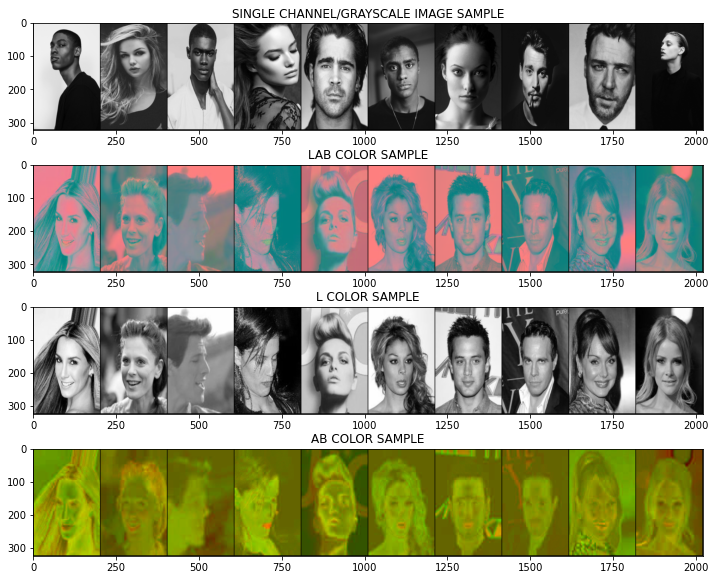

In [14]:
g_ims = next(iter(gray_data_loader))
l_ims = next(iter(l_data_loader))
ab_ims = next(iter(ab_data_loader))
lab_ims = next(iter(lab_data_loader))
rgb_ims = next(iter(rgb_data_loader))

plt.figure(figsize=(12, 10))
plt.axis('off')

im = make_grid(g_ims[:10], nrow=10, normalize=True)

plt.subplot(411)
plt.imshow(np.transpose(im, axes=(1, 2, 0)))
plt.title("SINGLE CHANNEL/GRAYSCALE IMAGE SAMPLE")

im = make_grid(lab_ims[:10], nrow=10, normalize=True)

plt.subplot(412)
plt.imshow(np.transpose(im, axes=(1, 2, 0)))
plt.title("LAB COLOR SAMPLE")

im = make_grid(l_ims[:10], nrow=10, normalize=True)

plt.subplot(413)
plt.imshow(np.transpose(im, (1, 2, 0)))
plt.title("L COLOR SAMPLE")

im = make_grid(ab_ims[:10], nrow=10, normalize=True)
im = np.stack([im[0], im[1], np.zeros((im.shape[1], im.shape[2]))])

plt.subplot(414)
plt.imshow(np.transpose(im, (1, 2, 0)))
plt.title('AB COLOR SAMPLE')

plt.show()

In [15]:
device = torch.device('cuda' if is_cuda else 'cpu')
device

device(type='cuda')

####  Convolutional Neural Network Model

In [26]:
class ColorizingNet(nn.Module):

    def __init__(self, in_features=1, out_features=2):
        super().__init__()

        resnet = models.resnet34(pretrained=True)
        # Change the first convolutional layer to accept single channel images.
        resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(dim=1))

        # ResNet-34 number of output features.
        self.resnet_out_channels = 128

        self.in_features = in_features
        self.out_features = out_features

        self.resnet = nn.Sequential(*list(resnet.children())[:-4])
        self.localize_sequence = self.localize_layer((128, 64, 32, 16, 8, 4))

    def localize_layer(self, n_layers):
        layers, n_in = [], self.resnet_out_channels

        for i, nl in enumerate(n_layers):
            i += 1

            layers.append(nn.Conv2d(in_channels=n_in,
                                    out_channels=nl,
                                    kernel_size=3,
                                    stride=1,
                                    padding=1))
            layers.append(nn.BatchNorm2d(nl))
            layers.append(nn.ReLU())
            layers.append(nn.Upsample(scale_factor=2.))

            if i % 2 == 0:
                layers.append(nn.AvgPool2d(kernel_size=2, stride=2))

            n_in = nl

        layers.append(nn.Conv2d(in_channels=n_in,
                                out_channels=self.out_features,
                                kernel_size=3,
                                stride=1, padding=1))

        return nn.Sequential(*layers)

    def forward(self, X):
        X = self.resnet(X)
        return self.localize_sequence(X)


model = ColorizingNet().to(device)
model


ColorizingNet(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [25]:
with torch.no_grad():

    model.eval()

    s = model(l_ims[0].to(device).view(-1, 1, HEIGHT, WIDTH))
    print(s.shape)

# s = torch.stack([l_ims[0][0], s[0, 0].cpu(), s[0, 1].cpu()]) * 255
# s = np.transpose(s.detach().view(-1, HEIGHT, WIDTH).numpy(), axes=(1, 2, 0)).astype(np.uint8)
# s = cv2.cvtColor(s, code=cv2.COLOR_LAB2RGB)

torch.Size([1, 2, 320, 200])


In [27]:
count = 0
for params in model.parameters():
  count += params.numel()

count

1588126

#### Training Neural Network Models

In [28]:
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=10e-4, betas=(0.5, 0.999))

In [29]:
# Clearup the CUDA memory occupied by previous training cycle.
torch.cuda.empty_cache()
gc.collect()

60

In [30]:
epoch = 2
losses = []

start = time.time()

for i in range(epoch):
    i += 1

    batch_time = time.time()

    for batch, (X, y) in enumerate(zip(l_data_loader, ab_data_loader)):
        batch += 1

        X = X.to(device)
        y = y.to(device)

        y_pred = model(X)
        loss = criterion(y_pred, y)

        if batch % 100 == 0 or batch == 1:
            losses.append(loss)
            print(f'Epoch: {i}, Batch: {batch} -> Loss: {loss}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

duration = time.time() - start
print(f'Duration to total execution: {duration / 60:.2f} minutes')

Epoch: 1, Batch: 1 -> Loss: 0.5442720651626587
Epoch: 1, Batch: 100 -> Loss: 0.0022794350516051054
Epoch: 1, Batch: 200 -> Loss: 0.002801381517201662
Epoch: 1, Batch: 300 -> Loss: 0.0030904957093298435
Epoch: 1, Batch: 400 -> Loss: 0.0020838798955082893
Epoch: 1, Batch: 500 -> Loss: 0.0018597636371850967
Epoch: 1, Batch: 600 -> Loss: 0.0029280513990670443
Epoch: 1, Batch: 700 -> Loss: 0.002920406637713313
Epoch: 1, Batch: 800 -> Loss: 0.0029784764628857374
Epoch: 1, Batch: 900 -> Loss: 0.0016699966508895159
Epoch: 1, Batch: 1000 -> Loss: 0.0020821066573262215
Epoch: 1, Batch: 1100 -> Loss: 0.0015649962006136775
Epoch: 1, Batch: 1200 -> Loss: 0.0013423421187326312
Epoch: 1, Batch: 1300 -> Loss: 0.0013626900035887957
Epoch: 1, Batch: 1400 -> Loss: 0.0026201365981251
Epoch: 1, Batch: 1500 -> Loss: 0.00175907660741359
Epoch: 1, Batch: 1600 -> Loss: 0.0016023516654968262
Epoch: 1, Batch: 1700 -> Loss: 0.0015546787763014436
Epoch: 1, Batch: 1800 -> Loss: 0.0016942891525104642
Epoch: 1, Batch

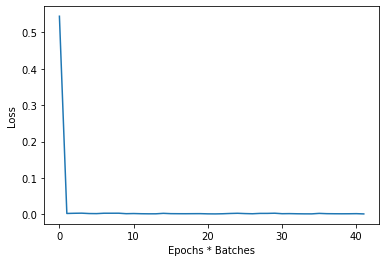

In [31]:
plt.plot(losses)
plt.xlabel('Epochs * Batches')
plt.ylabel('Loss')

del losses

In [19]:
# torch.save(model.state_dict(), '../state_dict/colorizing_net.pth')

#### Validate images with same dataset used to train.

In [32]:
@torch.no_grad()
def validate(img):

    model.eval()

    ab = model(img.to(device))

    lab = np.stack([img[0, 0], ab.cpu()[0, 0], ab.cpu()[0, 1]], axis=0) * 255

    lab = np.transpose(lab, axes=(1, 2, 0)).astype(np.uint8)
    lab = cv2.cvtColor(lab, code=cv2.COLOR_LAB2RGB)

    return lab

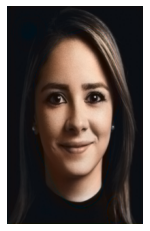

In [33]:
# validate(g_ims[9].view(-1, 1, HEIGHT, WIDTH))

gray_batch = next(iter(gray_data_loader))
batch = torch.stack([torch.tensor(validate(img.view(1, 1, HEIGHT, WIDTH))) for img in gray_batch])

# im = make_grid(batch, nrow=10, normalize=True)

plt.axis('off')
plt.imshow(batch[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
tensor(0.1882) tensor(-0.2902)


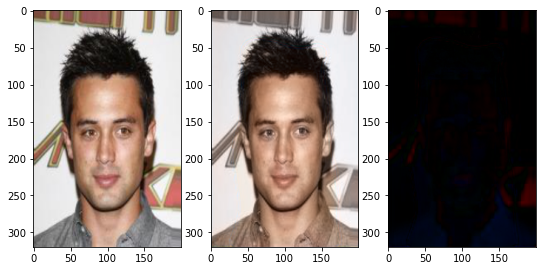

In [34]:
IMG_INDEX = 6

with torch.no_grad():

    model.eval()

    plt.figure(figsize=(9, 8))
    plt.subplot(131)
    plt.imshow(np.transpose(rgb_ims[IMG_INDEX], axes=(1, 2, 0)))

    s = model(l_ims[IMG_INDEX].to(device).view(-1, 1, HEIGHT, WIDTH))
    s = torch.stack([l_ims[IMG_INDEX][0], s[0, 0].cpu(), s[0, 1].cpu()]) * 255
    s = np.transpose(s.detach().view(-1, HEIGHT, WIDTH).numpy(), axes=(1, 2, 0)).astype(np.uint8)
    s = cv2.cvtColor(s, code=cv2.COLOR_LAB2RGB)

    plt.subplot(132)
    plt.imshow(s)

    org = np.transpose(rgb_ims[IMG_INDEX], axes=(1, 2, 0))
    pred = torch.Tensor(s) / 255

    diff = torch.sub(input=org, other=pred)

    print(diff[:, :, 2].max(), diff[:, :, 2].min())

    plt.subplot(133)
    plt.imshow(diff)